In [1]:
import gym
import math
import os
import random
import gc
import copy
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

from collections import deque

In [2]:
if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


# DQN algo:

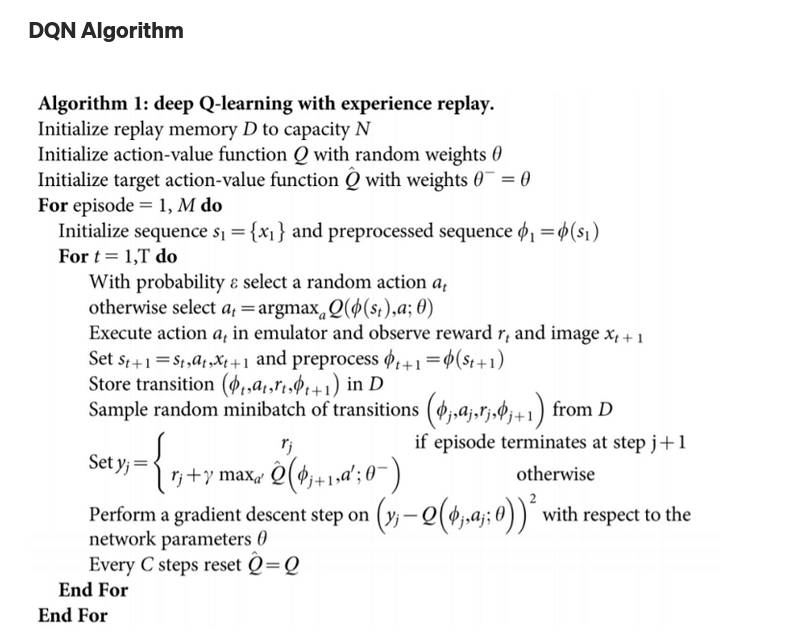

lets build objects in order  they appear on list

references on solving problems i ran into with code:

https://stackoverflow.com/questions/56964657/cartpole-v0-loss-increasing-using-dqn

https://levelup.gitconnected.com/dqn-from-scratch-with-tensorflow-2-eb0541151049

https://adgefficiency.com/dqn-tuning/

https://www.oreilly.com/library/view/python-cookbook/0596001673/ch05s19.html

https://wandb.ai/safijari/dqn-tutorial/reports/Deep-Q-Networks-DQN-With-the-Cartpole-Environment--Vmlldzo4MDc2MQ

https://stackoverflow.com/questions/48547688/tensorflow-keras-copy-weights-from-one-model-to-another

https://github.com/jacobaustin123/pytorch-dqn

In [3]:
class replay_memory:
    """ 
    class that implements a not-yet-full buffer 
    repurposed a ring buffer rather than writing a replay memory using the examples that are not great with deque
    """
    def __init__(self,size_max = 10000): #max size suggested at 1k to 100k using 1k to limit samples to more recent ones
        self.max = size_max
        self.data = []

    class __Full:
        """ class that implements a full buffer """
        def remember(self, x):
            """ Append an element overwriting the oldest one. """
            self.data[self.cur] = x
            self.cur = (self.cur+1) % self.max
        def get_batch(self, n = 256): #batch size suggested at 64 to 512 samples
            """ return list of elements in correct order """
            batch_size = min(n, len(self.data))
            return random.choices(self.data, k = batch_size)

    def remember(self,x):
        """append an element at the end of the buffer"""
        self.data.append(x)
        if len(self.data) == self.max:
            self.cur = 0
            # Permanently change self's class from non-full to full
            self.__class__ = self.__Full

    def get_batch(self, n = 256): #batch size suggested at 64 to 512 samples
        """ Return a list of elements from the oldest to the newest. """
        batch_size = min(n, len(self.data))
        return random.choices(self.data, k = batch_size)
    

In [4]:
class q_action_value_network:
    """
    q_action_value_network
    
    this is the action-value function approximator
    """
    
    def __init__(self, \
                 input_size = 4 , \
                 output_size = 2, \
                 num_hidden_layers= 2, \
                 learning_rate = 0.0005): #suggest learn rate btw .001 and .0001
        """
        initialization
        input_size is the state size
        num_hidden_layers  is how many hidden layers will be used
        learning_rate is the learning rate for the adam optimizer
        gamma is the discount rate
        """
        self.input_size = input_size 
        self.output = output_size
        self.num_hidden_layers = num_hidden_layers
        self.learning_rate = learning_rate
        self.model = self.build_model()
    
    def build_model(self):
        """
        function to build the model based on passed inputs
        """
        q_net = tf.keras.Sequential()
        q_net.add(tf.keras.layers.Dense(16, input_dim=self.input_size, activation='relu', kernel_initializer='he_uniform'))
        for i in range(self.num_hidden_layers):
            q_net.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform'))
        q_net.add(tf.keras.layers.Dense(self.output, activation='linear', kernel_initializer='he_uniform'))
        q_net.compile(optimizer=tf.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return q_net
    
    def train_model(self, targets, states):
        """
        function to train model

        """            
        #print(states)
        #print(targets)
        result = self.model.fit(x = np.array(states), y = np.array(targets), verbose = 0)
        
        keras.backend.clear_session() 
        del states
        del targets
        gc.collect()
        return result.history['loss'][0]


In [5]:
class agent_class:
    """
    agent class to contain replay buffer and q action value functions
    """
    
    def __init__(self, \
                 environment = 'CartPole-v1', \
                 max_steps = 200, \
                 check_ep = 200, \
                 c = 1000, \
                 update_freq = 10, \
                 epsilon = 0.20, \
                 gamma = 0.99):
        
        """
        init for agents
        
        environment defines which gym environment we will play
        c is the number of steps to flip the q and q hat networks
        """
        self.c = c # how many steps to flip models deep mind say 10k open ai 1k
        self.env = gym.make(environment)
        self.max_steps = max_steps #max steps in episode , set at 200 to emulate original cart pole env v0
        self.check_ep = check_ep # how many episdoes to print telemetry
        self.epsilon = epsilon #explore/exploit, should do an eps decay function to start with high explore to help learn
        self.initial_epsilon = epsilon #initial eps
        self.gamma = gamma
        self.update_freq = update_freq #how many steps between retraining neural net
        self.inputs = len(self.env.observation_space.low)
        self.actions = self.env.action_space.n
        self.replay_buffer = replay_memory()
        
        #build networks
        #this also needs to be tweaked to deal with some level of adjustible learning rate or learning rate scheduling
        self.q = q_action_value_network(input_size = self.inputs , output_size = self.actions)
        self.q_hat = q_action_value_network(input_size = self.inputs , output_size = self.actions)
        self.losses = []
        
    def policy(self, state):
        """
        select action to take

        """
        #print(state)
        #print([self.q_hat.predict(state, act) for act in self.actions])
        if np.random.rand() <= self.epsilon:
            #if random is less than the exploit prob
            #get max action
            prediction = self.q.model.predict(state, verbose = 0)
            #print(prediction)
            action = np.argmax(prediction[0], axis=0)
        else:
            #select non max action
            action = np.random.choice([x for x in range(self.actions)])
            
        keras.backend.clear_session() 
        gc.collect() 
        return action
    
    def q_training(self):
        """
        trains q model used for chosing actions
        #sample from buffer                     
        #replay_buffer is to pass the replay buffer to sample from
        #our replay retuns a list of lists in the format
        #[state, next_state, action, reward, done]
        
        """

        
        targets = []
        batch = self.replay_buffer.get_batch()
        
        # listcomprehension tos tack states and next states
        states = [item[0][0] for item in batch]
        next_states = [item[1][0] for item in batch]
        
        #batch predict the q_hat/target and action selection values
        #qhat/target preds for advantage
        q_hat_predictions = self.q_hat.model.predict(np.array(next_states), verbose = 0)
        #predictions for policy q/action selection q
        q_predictions = self.q.model.predict(np.array(states), verbose = 0)
        
        #fun iterative stuff 
        for i in range(len(batch)):
            if batch[i][4]:
                target = batch[i][3] #target = reward if done/terminal
            else:               
                #take the max value
                max_pred = np.max(q_hat_predictions[i], axis=0)
                
                #reward + (gamma * max value for next state)
                target = batch[i][3] + (self.gamma * max_pred)
                
            q_predictions[i][batch[i][2]] = target
            targets.append(q_predictions[i])

            #print(states)
            #print(targets)

        #train q model and track model losses
        #print('training')
        self.losses.append(self.q.train_model(targets, states))
        #print('done training')
        
        #force memory clean ups
        del target
        del q_predictions 
        del batch
        del targets
        del states
        del q_hat_predictions
        del max_pred
        keras.backend.clear_session() 
        gc.collect() 
        
    def epsilon_decay(self, c_steps):
        """
        decays epsilon
        """
        final_epsilon = 0.95
        epsilon_decay = 20000
        
        self.epsilon = final_epsilon - ((final_epsilon - self.initial_epsilon) * math.exp(-1. * c_steps / epsilon_decay))
    
        
    def run_episodes(self, \
                     n = 10000, \
                     train = 1):
        """
        run episodes
        
        n = number of episodes to run
        train = training or pure exploitation
        """
        complete_scores = []
        self.losses = []
        actions = []
        c_steps = 0         
        
        for i in range(n):
            gc.collect()
            score = 0
            steps = 0
            
            state = self.env.reset()[0][None, :]
            
            while True:
                
                if train:
                    action = self.policy(state)
                    
                    actions.append(action)

                    next_state, reward, done, _f, _ = self.env.step(action)
                    next_state = next_state[None,:]
                    #print(next_state)

                    steps += 1

                    if steps >= self.max_steps:
                        done = 1                    
                    
                    self.replay_buffer.remember([state, next_state, action, reward, done])
                                        
                    if c_steps > 0 and c_steps % self.c == 0:
                        #print("flip model weights")
                        self.q_hat.model.set_weights(self.q.model.get_weights()) 
                    
                    if c_steps > 0 and c_steps % self.update_freq == 0:
                        #update action selection model
                        self.q_training()
                    
                    c_steps += 1                    
                    score += reward
                    state = next_state
                    self.epsilon_decay(c_steps)
                        
                else:
                    action = np.argmax(self.q.model.predict(state, verbose = 0))
                    next_state, reward, done, _f, _ = self.env.step(action)
                    next_state = next_state[None,:]
                    
                    steps += 1

                    if steps >= self.max_steps:
                        done = 1
                    
                    score += reward
                    state = next_state
                    self.losses.append(0)
  
                #memory stuff
                keras.backend.clear_session()
                gc.collect()
                
                if done:                    
                    complete_scores.append(score)
                    break
        
            if train:
                #early stopping/exit if model is consistently 5 away from max step limit in env
                if np.mean(complete_scores[-20:]) >= (self.max_steps - 5):
                    print("convergence has been attained")
                    print("total steps observed in env thru all episodes:", c_steps)
                    print("current epsilon:", self.epsilon)
                    break
                    
                if len(complete_scores) == 1 or len(complete_scores) % self.check_ep == 0:
                    print("episode:", i + 1, "score: ", score)
                    print("avg score over last ", min(self.check_ep, len(complete_scores)) , " run(s):", np.mean(complete_scores[-self.check_ep:]))
                    print("total steps observed in env thru all episodes:", c_steps)
                    
                    #basic epsilon decay
                    print("current epsilon:", self.epsilon)
                    #print("last 10 actions: " , actions[-10:])
                    print("last loss:" , self.losses[-1])
                    


                    
        #when complete plot results        
        self.env.close()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey='row')
        ax1.plot(np.arange(len(complete_scores)), complete_scores)
        ax1.set_title('Total Scores Over Episodes')
        ax2.plot(np.arange(len(self.losses)), self.losses)
        ax2.set_title('Losses Over Training Steps')
        plt.show()            
       

episode: 1 score:  18.0
avg score over last  1  run(s): 18.0
total steps observed in env thru all episodes: 18
current epsilon: 0.20067469634110446
last loss: 3.483656167984009
episode: 200 score:  17.0
avg score over last  200  run(s): 16.58
total steps observed in env thru all episodes: 3316
current epsilon: 0.31458825471628127
last loss: 0.0973329022526741
episode: 400 score:  198.0
avg score over last  200  run(s): 69.125
total steps observed in env thru all episodes: 17141
current epsilon: 0.6316908098326033
last loss: 0.13568250834941864
episode: 600 score:  146.0
avg score over last  200  run(s): 130.79
total steps observed in env thru all episodes: 43299
current epsilon: 0.8639332458219137
last loss: 0.13602709770202637
convergence has been attained
total steps observed in env thru all episodes: 71376
current epsilon: 0.9288577542612181


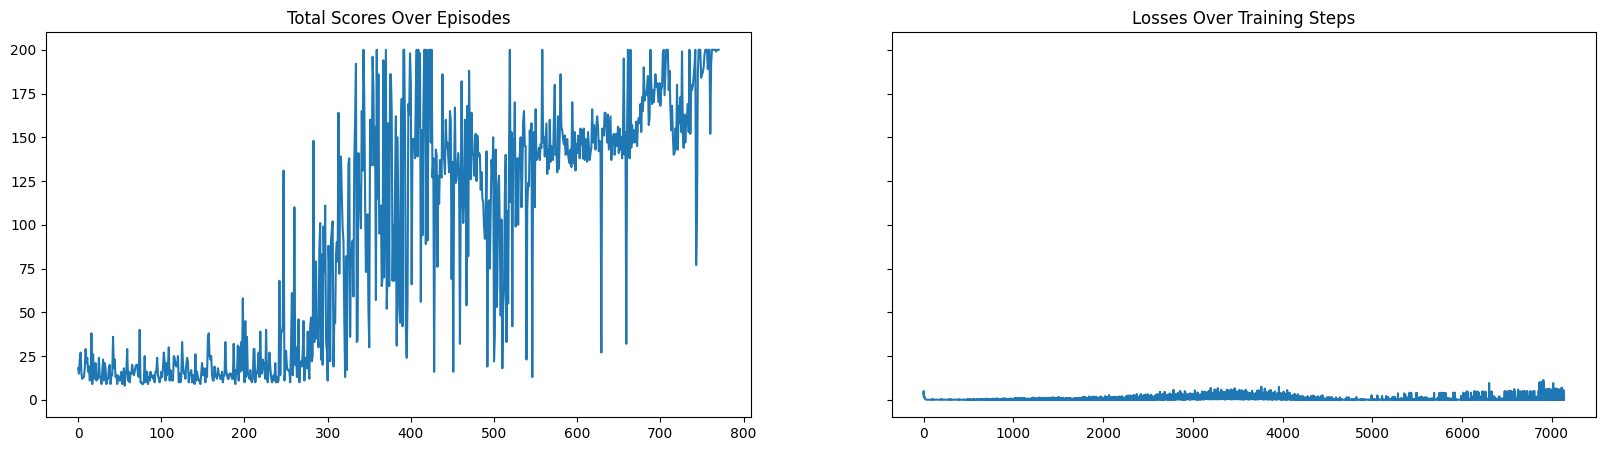

In [6]:
agent = agent_class()

agent.run_episodes(n = 10000)

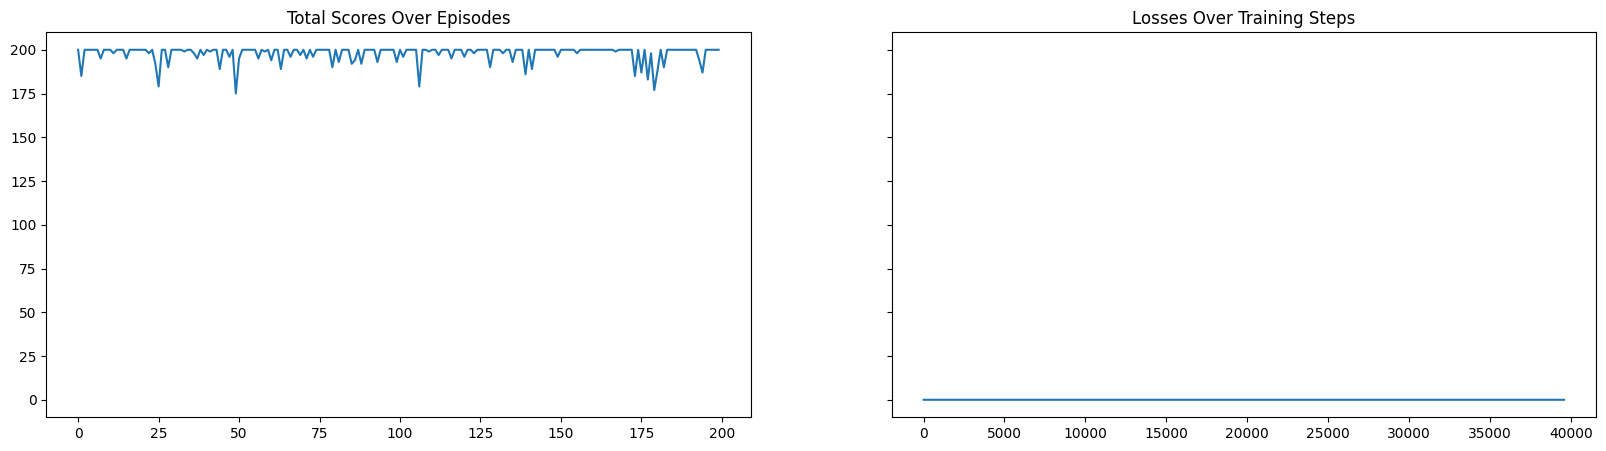

In [7]:
agent.run_episodes(n = 200, train = 0)

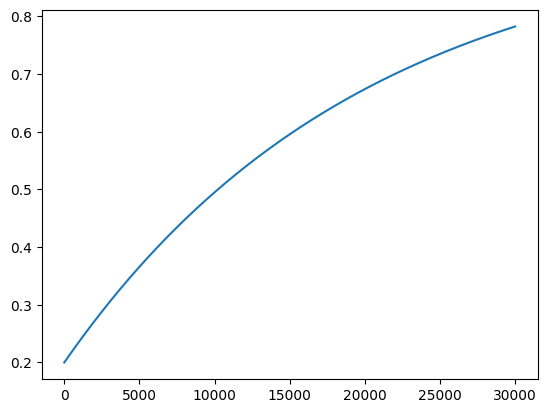

In [9]:
#explore decay where epsilon is how much exploit 
import numpy as np
import math

dummy_list = []
initial_epsilon = .20
final_epsilon = 0.95
epsilon_decay = 20000
epsilon = initial_epsilon

for c_steps in range(30000):
    epsilon = final_epsilon - ((final_epsilon - initial_epsilon) * math.exp(-1. * c_steps / epsilon_decay))
    
    dummy_list.append(epsilon)
    
import matplotlib.pyplot as plt

#plot decay curve to show how it changes over the cumulative steps taken
plt.plot(np.arange(len(dummy_list)), dummy_list)

plt.show()